In [16]:
# Example usage:
power_watts = 300  # Power consumption of the PC in watts
hours_per_day = 24  # Hours of usage per day
price_per_kwh = 0.23719  # Price per kWh in euros
number_of_days = 5

# Calculate daily energy consumption in kWh
daily_energy_kwh = (power_watts * hours_per_day) / 1000

# Calculate annual energy consumption in kWh
energy_kwh = daily_energy_kwh * number_of_days  # Assuming a non-leap year

# Calculate annual cost
cost = energy_kwh * price_per_kwh

print(f"The following cost me {cost:.2f}€ to train. Hope it works !")

lambda_labs = 0.75 #e/h
nb_h = hours_per_day*number_of_days
cost = nb_h * lambda_labs
print(f"The following would have cost me {cost:.2f}€ to train. on lambda labs ...")

The following cost me 8.54€ to train. Hope it works !
The following would have cost me 90.00€ to train. on lambda labs ...


In [17]:
import torch

from dataset import MIR1KDataset
from crepe import CREPE

dataset = MIR1KDataset(root_dir="./dataset/MIR-1K")

crepe = CREPE(model_capacity="tiny")

audio, label = dataset[8]
audio = torch.tensor(audio)
label = torch.tensor(label)

/Users/chloelavrat/Documents/GitHub/TorchCrepe/crepe.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.path.join(package_dir, filename)

In [18]:
_, crepe_frequency, _, crepe_activation = crepe.predict(audio,16000)

torch.Size([925, 1024])


In [19]:
crepe_activation.shape

torch.Size([925, 360])

In [20]:
min_cents = 1200 * torch.log2(torch.tensor(32.70/10))
max_cents = 1200 * torch.log2(torch.tensor(1975.5/10))
print(min_cents)
print(max_cents)

tensor(2051.1487)
tensor(9151.2891)


In [21]:
def cent_to_bin_mapping(cents_values, dtype=torch.float32, device='cpu'):
    # Define the mapping parameters
    num_bins = 360
    min_cents = 1200 * torch.log2(torch.tensor(32.70/10))
    max_cents = 1200 * torch.log2(torch.tensor(3951.066/10)) + min_cents
    bin_edges = torch.linspace(min_cents, max_cents, num_bins, dtype=dtype, device=device)
    
    # Compute the bin index for each cent value
    # Find the closest bin edge for each cent value
    bin_indices = torch.bucketize(cents_values, bin_edges, right=True)
    
    # Ensure bin indices are within bounds
    bin_indices = torch.clamp(bin_indices, min=0, max=num_bins-1)
    
    return bin_indices

In [29]:

import torch
import torch.nn as nn
from trainer import frequency_to_cents
from utils import * 
import torch.nn.functional as F

def get_activation_from_label(labels, center=True, step_size=10, batch_size=128):
    """     
    labels : (N,) or (C, N)
    """
    
    if len(labels.shape) == 2:
        if labels.shape[0] == 1:
            labels = labels[0]
        else:
            labels = labels.mean(dim=0) # make mono

    def get_frame(labels, step_size, center):
        if center:
            labels = nn.functional.pad(labels, pad=(512, 512))
        # make 1024-sample frames of the labels with hop length of 10 milliseconds
        hop_length = int(16000 * step_size / 1000)
        n_frames = 1 + (len(labels) - 1024) // hop_length
        frames = torch.as_strided(labels, size=(1024, n_frames), stride=(1, hop_length))
        frames = frames.transpose(0, 1).clone()
    
        return frames
        
    frames = get_frame(labels, step_size, center)
    activation_stack = []
    
    for i in range(0, len(frames), batch_size):
        f = frames[i:min(i+batch_size, len(frames))]
        act = torch.zeros([f.shape[0],360])
        mean_f = f.mean(dim=-1)
        bins = cent_to_bin_mapping(mean_f)
        for idx, a in enumerate(act):
            act[idx,bins[idx]]=1

        activation_stack.append(act.cpu())
    activation = torch.cat(activation_stack, dim=0)
    return activation

# resize cents to audio size
label_F = F.interpolate(label.unsqueeze(0).unsqueeze(0), size = audio.shape[-1], mode='linear').squeeze(0).squeeze(0)
label_F = frequency_to_cents(label_F)
# convert cents to activations
label_activation = get_activation_from_label(label_F)
#print("label_activation", label_activation.shape)
#print("crepe_activation", crepe_activation.shape)
label_freq = to_freq(label_activation)
crepe_freq = to_freq(crepe_activation)

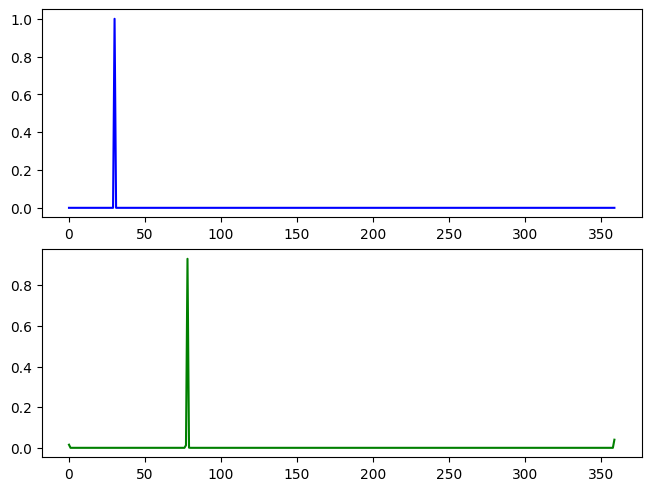

tensor(30)


In [30]:
from matplotlib import pyplot as plt

idx = 70

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(label_activation[idx,:], 'b')
ax1.plot(crepe_activation[idx,:].detach().numpy(), 'g')
plt.show()
print(label_activation[idx,:].argmax())

tensor(0.4111)


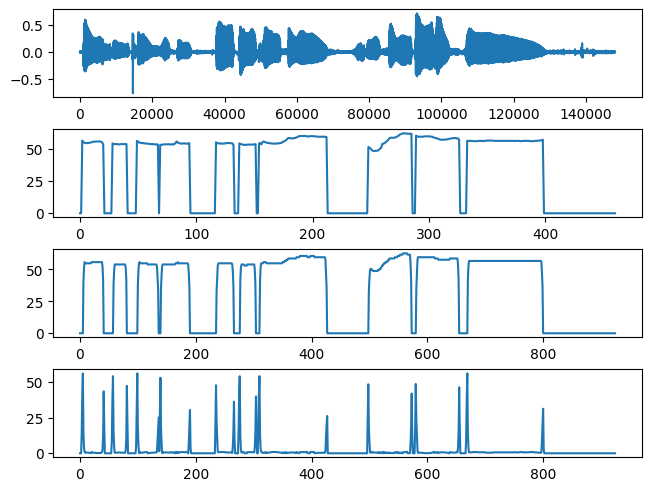

In [31]:
from matplotlib import pyplot as plt

diff = torch.abs(label_freq - F.interpolate(label.unsqueeze(0).unsqueeze(0), size = label_freq.shape[-1], mode='linear').squeeze(0).squeeze(0))
print(diff.median())

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, layout='constrained')
ax0.plot(audio)
ax1.plot(label)
ax2.plot(label_freq)
ax3.plot(diff)
#ax4.plot(crepe_freq.detach().numpy())
plt.show()

In [25]:
print("label max freq",label.max())
print("label_freq max freq",label_freq.max())
print("-"*5)
print("label min freq",label.min())
print("label_freq min freq",label_freq.min())

label max freq tensor(61.8368)
label_freq max freq tensor(62.6098)
-----
label min freq tensor(0.)
label_freq min freq tensor(1.0000e-07)


In [26]:
a = torch.tensor([1.9383e-01, 8.3104e-07, 6.9584e-07, 6.9541e-07, 7.4688e-07, 6.8756e-07,
        5.3404e-07, 4.1513e-07, 4.0454e-07, 5.1323e-07, 7.2838e-07, 9.8690e-07,
        1.2166e-06, 1.4998e-06, 2.0409e-06, 2.6032e-06, 3.1154e-06, 3.5271e-06,
        3.4064e-06, 2.7146e-06, 1.9671e-06, 1.3718e-06, 8.4304e-07, 4.7868e-07,
        3.0768e-07, 2.5058e-07, 2.8591e-07, 3.8736e-07, 5.7415e-07, 9.6277e-07,
        1.3007e-06, 1.2728e-06, 1.0783e-06, 8.4836e-07, 6.0312e-07, 4.8678e-07,
        6.2461e-07, 1.0507e-06, 1.7756e-06, 3.0083e-06, 4.2214e-06, 4.5419e-06,
        3.8967e-06, 3.2025e-06, 3.2180e-06, 4.1283e-06, 5.7265e-06, 6.6710e-06,
        5.3012e-06, 3.5813e-06, 2.7596e-06, 2.6151e-06, 2.8306e-06, 2.7247e-06,
        2.2116e-06, 1.6468e-06, 1.3646e-06, 1.2630e-06, 1.1070e-06, 1.0615e-06,
        9.8189e-07, 8.8630e-07, 9.8937e-07, 1.1560e-06, 1.0284e-06, 8.1576e-07,
        7.4328e-07, 7.1227e-07, 6.5930e-07, 7.2608e-07, 7.6801e-07, 7.7339e-07,
        7.9158e-07, 9.1846e-07, 1.1627e-06, 1.2429e-05, 2.6847e-04, 3.5550e-03,
        7.9313e-01, 1.7961e-03, 5.5851e-07, 2.8857e-07, 1.7782e-07, 1.3480e-07,
        9.7270e-08, 8.8624e-08, 1.0550e-07, 1.5187e-07, 2.1273e-07, 2.5626e-07,
        3.0231e-07, 3.7964e-07, 4.1704e-07, 3.0524e-07, 2.0359e-07, 1.6860e-07,
        1.8619e-07, 2.5027e-07, 3.9765e-07, 5.9423e-07, 5.4063e-07, 4.2637e-07,
        3.7690e-07, 4.3527e-07, 5.1235e-07, 6.4219e-07, 8.9857e-07, 1.2806e-06,
        1.4546e-06, 1.3857e-06, 1.0924e-06, 6.9726e-07, 4.4240e-07, 4.2287e-07,
        5.6977e-07, 7.1241e-07, 7.5092e-07, 5.9798e-07, 3.9834e-07, 2.9180e-07,
        2.3838e-07, 2.3865e-07, 2.8269e-07, 3.3948e-07, 3.7242e-07, 3.2614e-07,
        3.2251e-07, 3.4530e-07, 2.8732e-07, 2.9788e-07, 5.4061e-07, 1.0400e-06,
        1.4061e-06, 1.6389e-06, 2.1865e-06, 2.5219e-06, 2.7685e-06, 3.3331e-06,
        3.1811e-06, 1.6799e-06, 6.4440e-07, 3.0289e-07, 2.0205e-07, 1.4498e-07,
        1.0994e-07, 9.5795e-08, 8.9903e-08, 9.2018e-08, 9.4205e-08, 1.0054e-07,
        1.2532e-07, 1.1239e-07, 8.4303e-08, 6.6422e-08, 6.1249e-08, 6.4027e-08,
        6.3517e-08, 8.5947e-08, 1.6316e-07, 2.0828e-07, 1.6151e-07, 1.3033e-07,
        1.4335e-07, 2.0189e-07, 2.8379e-07, 3.3608e-07, 3.3280e-07, 2.8795e-07,
        1.9510e-07, 1.6818e-07, 1.7161e-07, 1.5636e-07, 1.2727e-07, 9.3431e-08,
        7.0409e-08, 5.4087e-08, 5.2952e-08, 4.8437e-08, 3.7177e-08, 2.6947e-08,
        2.1785e-08, 2.5099e-08, 3.2565e-08, 3.2417e-08, 2.9878e-08, 2.4651e-08,
        2.1888e-08, 2.1100e-08, 1.9276e-08, 1.9999e-08, 3.0942e-08, 5.5231e-08,
        8.0380e-08, 1.0537e-07, 1.8409e-07, 2.7667e-07, 2.6118e-07, 1.4182e-07,
        5.7367e-08, 3.7700e-08, 3.4720e-08, 3.7872e-08, 6.8016e-08, 9.4255e-08,
        7.7559e-08, 4.8117e-08, 4.4807e-08, 6.0353e-08, 7.8967e-08, 1.1489e-07,
        1.4379e-07, 1.3201e-07, 1.0950e-07, 9.6761e-08, 8.5351e-08, 9.0866e-08,
        1.4125e-07, 2.0852e-07, 1.6934e-07, 1.5857e-07, 1.2827e-07, 1.0294e-07,
        1.4766e-07, 2.4273e-07, 3.8038e-07, 5.1353e-07, 9.2069e-07, 2.0584e-06,
        2.5136e-06, 3.5282e-06, 4.2602e-06, 4.3090e-06, 4.2516e-06, 3.6246e-06,
        2.1076e-06, 1.0226e-06, 5.6122e-07, 2.2318e-07, 6.9068e-08, 2.2706e-08,
        9.4267e-09, 7.2841e-09, 1.3057e-08, 2.0138e-08, 1.7833e-08, 2.2478e-08,
        3.7572e-08, 4.7680e-08, 5.5761e-08, 8.6446e-08, 1.4154e-07, 2.0062e-07,
        2.8063e-07, 3.5133e-07, 2.4533e-07, 1.6396e-07, 1.4191e-07, 9.2064e-08,
        3.9572e-08, 1.7594e-08, 1.2891e-08, 1.5607e-08, 1.5929e-08, 2.3446e-08,
        3.6269e-08, 3.2811e-08, 2.4758e-08, 2.0824e-08, 1.9533e-08, 2.2710e-08,
        3.0705e-08, 4.2147e-08, 4.8942e-08, 3.9462e-08, 5.0365e-08, 1.1275e-07,
        2.0426e-07, 1.7243e-07, 1.1929e-07, 7.3213e-08, 4.2306e-08, 4.5350e-08,
        8.7472e-08, 1.5716e-07, 1.7844e-07, 2.2993e-07, 3.5239e-07, 5.3506e-07,
        8.3646e-07, 1.1530e-06, 1.3320e-06, 1.5895e-06, 1.5266e-06, 1.0620e-06,
        5.5465e-07, 2.8412e-07, 1.6709e-07, 7.7700e-08, 2.8519e-08, 9.3762e-09,
        2.3457e-09, 1.2239e-09, 3.3622e-09, 1.2019e-08, 1.8821e-08, 2.1592e-08,
        3.1068e-08, 3.5919e-08, 5.7424e-08, 1.8261e-07, 3.7444e-07, 4.8074e-07,
        5.6025e-07, 6.1724e-07, 6.9626e-07, 6.8640e-07, 4.5826e-07, 3.1287e-07,
        2.0284e-07, 1.9589e-07, 3.7154e-07, 5.8828e-07, 4.9183e-07, 4.3414e-07,
        5.5285e-07, 6.1045e-07, 6.5986e-07, 8.2714e-07, 9.1866e-07, 9.8166e-07,
        1.0196e-06, 6.6994e-07, 3.5846e-07, 1.8764e-07, 1.3175e-07, 1.0218e-07,
        9.5281e-08, 1.0150e-07, 1.2335e-07, 1.8485e-07, 1.6799e-07, 1.1185e-07,
        6.5219e-08, 5.2956e-08, 1.0405e-07, 2.3310e-07, 4.5575e-07, 5.0148e-07,
        4.8034e-07, 5.1233e-07, 3.7967e-07, 2.7747e-07, 2.6799e-07, 2.3737e-07,
        1.8924e-07, 1.0278e-07, 4.6707e-08, 2.3567e-08, 1.1278e-08, 8.2957e-05])


In [27]:
a.shape

torch.Size([360])

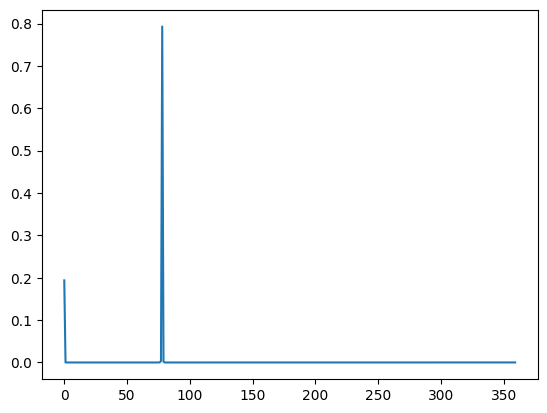

In [28]:
plt.plot(a)
plt.show()